In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ngmix
import numpy as np
import galsim

In [4]:
from ngmix.adaptive_prepsfmom import PrePSFAdmom
from ngmix.prepsfmom import PGaussMom
from wldeblend_sim import init_wldeblend, get_gal_wldeblend, make_ngmix_obs

In [43]:
import tqdm

wldeblend_data = init_wldeblend(survey_bands="lsst-r")

rng = np.random.RandomState()
ap = 2

s2n_true = []
s2n_pg = []
s2n_pam = []
for _ in tqdm.trange(1000, ncols=79):
    gal, psf, redshift = get_gal_wldeblend(rng=rng, data=wldeblend_data)
    obs, true_flux, obs_nn = make_ngmix_obs(
        gal=gal, psf=psf, nse=wldeblend_data.noise, pixel_scale=wldeblend_data.pixel_scale, rng=rng,
    )
    
    res = PGaussMom(ap).go(obs)
    pres = PrePSFAdmom(ap, delta_fwhm=0.1).go(obs)
    s2n_pg.append(res["s2n"])
    s2n_pam.append(pres["s2n"])
    s2n_true.append(obs.get_s2n())

 10%|███▉                                   | 100/1000 [00:49<07:22,  2.03it/s]


KeyboardInterrupt: 

In [44]:
s2n_pg = np.array(s2n_pg)
s2n_pam = np.array(s2n_pam)
s2n_true = np.array(s2n_true)

inds = np.argsort(s2n_true)
s2n_pg = s2n_pg[inds]
s2n_pam = s2n_pam[inds]
s2n_true = s2n_true[inds]

(0.8, 1.2)

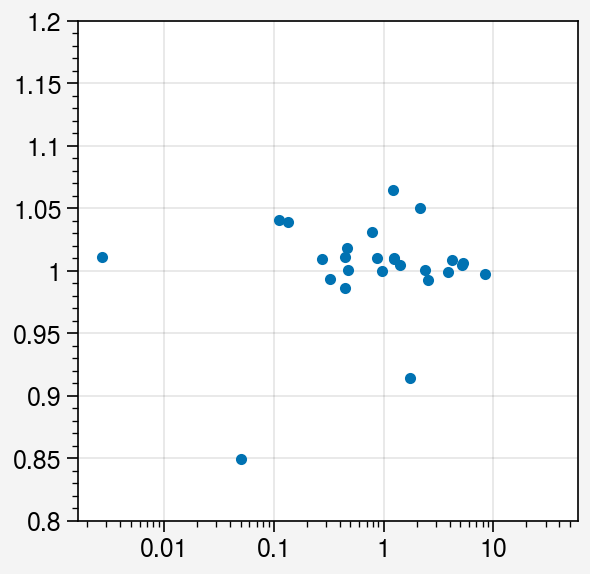

In [45]:
import proplot as pplt

fig, axs = pplt.subplots()

axs.semilogx(s2n_true, s2n_pam/s2n_pg, '.')
axs.set_ylim(0.8, 1.2)

In [96]:
from ngmix import Jacobian, Observation

rng = np.random.RandomState()
image_size = 101
psf_image_size = 53
pixel_scale = 0.2
snr = 2e1
fwhm = 0.5
psf_fwhm = 0.9

cen = (image_size - 1)/2
psf_cen = (psf_image_size - 1)/2
gs_wcs = galsim.ShearWCS(
    pixel_scale, galsim.Shear(g1=-0.1, g2=0.06)).jacobian()
scale = np.sqrt(gs_wcs.pixelArea())
shift = rng.uniform(low=-scale/2, high=scale/2, size=2)
psf_shift = rng.uniform(low=-scale/2, high=scale/2, size=2)
xy = gs_wcs.toImage(galsim.PositionD(shift))
psf_xy = gs_wcs.toImage(galsim.PositionD(psf_shift))

jac = Jacobian(
    y=cen + xy.y, x=cen + xy.x,
    dudx=gs_wcs.dudx, dudy=gs_wcs.dudy,
    dvdx=gs_wcs.dvdx, dvdy=gs_wcs.dvdy)

psf_jac = Jacobian(
    y=psf_cen + psf_xy.y, x=psf_cen + psf_xy.x,
    dudx=gs_wcs.dudx, dudy=gs_wcs.dudy,
    dvdx=gs_wcs.dvdx, dvdy=gs_wcs.dvdy)

gal = galsim.Gaussian(
    fwhm=fwhm
).shear(
    e1=-0.1, e2=0.2
).withFlux(
    400
).shift(
    dx=shift[0], dy=shift[1]
)

gal = galsim.Exponential(
    half_light_radius=fwhm,
).shear(
    e1=-0.1, e2=0.2
).withFlux(
    400
).shift(
    dx=shift[0], dy=shift[1]
)


psf = galsim.Gaussian(
    fwhm=psf_fwhm
).shear(
    g1=0.3, g2=-0.15
)
im = galsim.Convolve([gal, psf]).drawImage(
    nx=image_size,
    ny=image_size,
    wcs=gs_wcs
).array
noise = np.sqrt(np.sum(im**2)) / snr
wgt = np.ones_like(im) / noise**2

psf_im = psf.shift(
    dx=psf_shift[0], dy=psf_shift[1]
).drawImage(
    nx=psf_image_size,
    ny=psf_image_size,
    wcs=gs_wcs
).array

im_true = gal.drawImage(
    nx=image_size,
    ny=image_size,
    wcs=gs_wcs,
    method='no_pixel').array
obs_true = Observation(
    image=im_true,
    jacobian=jac,
)

obs = Observation(
    image=im + rng.normal(size=im.shape, scale=noise),
    weight=wgt,
    jacobian=jac,
    psf=Observation(image=psf_im, jacobian=psf_jac),
)

In [97]:
import pprint

mom_fwhm = 2

res = PrePSFAdmom(min_fwhm=mom_fwhm, delta_fwhm=1).go(obs)
pres = PGaussMom(fwhm=mom_fwhm).go(obs)
print("pgauss s/n:   ", pres["s2n"])
print("am pgauss s/n:", res["s2n"])
for key in pres.keys():
    if key in res:
        print("%s:\n    %s\n    %s" % (key, pprint.pformat(pres[key]), pprint.pformat(res[key])))

pgauss s/n:    18.996904518020905
am pgauss s/n: 4.175089621891306
flags:
    0
    8
flagstr:
    ''
    'T <= 0'
flux:
    299.3233395647707
    330.61904722547683
mom:
    array([         nan,          nan, -24.60882039,  45.86455316,
        77.97884559, 299.32333956])
    array([           nan,            nan, -1429.8371303 ,   960.83821243,
       -1607.12120011,   330.61904723])
mom_cov:
    array([[  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   1.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 272.25729355, -13.32836259,
         75.47711287, -46.93855394],
       [  0.        ,   0.        , -13.32836259, 252.30574421,
        -37.78818727,  23.50065699],
       [  0.        ,   0.        ,  75.47711287, -37.78818727,
        312.83854327, 105.70721841],
       [  0.        ,   0.        , -46.93855394,  23.50065699,
        105.70721841, 248.264